# Sumário
1. Inicialização
    * Importando Bibliotecas
    * Variáveis Globais
    * Funções
2. Carregando o Conjunto de Dados no Pandas
3. Pré-Processamento
    * Transformação das variáveis de data
    * Seleção das variáveis utilizadas no modelo
    * Substituição dos valores faltantes por 0 (para colunas numéricas) e NI (Não Informado - para colunas não numéricas)
    * Label Encoder - Codificando as strings em valores numéricos
4. Machine Learning
    * Carrega o modelo
    * Aplica o modelo no conjunto de teste
    * Salva o resultado da classificação em um arquivo

# Inicialização
* Importando Bibliotecas
* Variáveis Globais

## Importando Bibliotecas

In [1]:
## data
import pandas as pd
import numpy as np
import datetime as dt
from dateutil.relativedelta import relativedelta

## viz
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

## model
import statsmodels.api as sm
from sklearn.metrics import *
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.linear_model import LinearRegression
from numpy import log
from pmdarima.arima import auto_arima
from statsmodels.tsa.arima_model import ARIMA

import warnings
warnings.filterwarnings("ignore")
import matplotlib.dates as mdates

%matplotlib inline

# Variáveis Globais

In [2]:
# Coloque aqui o caminho ao qual o arquivo se encontra
PATH = '../Dados/Armarios/'

# Coloque aqui o nome do arquivo
file_train = 'consumo_sudeste.txt'

# Funções

## Seleção do estado a ser analisado

In [3]:
def uf_selection(uf, dataset, target, pattern):
    """ Create the dataframe based in the state wants to predict.

        Args:
            dataset (object/spreadsheet): The dataset under analysis.
            uf (string): The state under analysis.

        Returns:
            A dataframe with the state under analysis.
    """   
    dataset['mes'] = dataset['mes'].astype('string')
    dataset['mes'] = dataset['mes'].apply(lambda x: pd.to_datetime(str(x) + '01'))
    df.columns = df.columns.str.replace(pattern, '')
    dataset = dataset[['mes', target]].loc[dataset['uf'] == uf]
    
    return dataset

## Teste de estacionalidade de Dickey Fuller

In [4]:
def adf_test(dataset):
    """ Performs Augmented Dickey Fuller test.

        Args:
            dataset (object/spreadsheet): The dataset under analysis.

        Returns:
            The results of adf test.
    """   
    
    print('Resultado do Teste Dickey-Fuller:')
    dftest = adfuller(dataset, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Teste', 'Valor p', '# de lags', '# de observações'])
    for key, value in dftest[4].items():
        dfoutput['Valores Críticos ({})'.format(key)] = value
   
    print(dfoutput)

## Diferenciação da série e teste de estacionariedade na série diferenciada

In [10]:
def serie_differentiation(dataset, target):
    """ Create serie's differentiation.

        Args:
            dataset (object/spreadsheet): The dataset under analysis.
            target (string): The target under analysis.
            
        Returns:
            A plot with serie's differentiation, the results of adf test in the new serie and differentiation data.
    """     
     
    plt.figure(figsize=(15, 5))
    df_diff = np.diff(dataset[target])
    plt.plot(df_diff)

    print(adf_test(df_diff))
    
    return df_diff

## Autocorrelação Mensal

In [11]:
def autocorrelation_lag(dataset, target):
    """ Print autocorrelation based in 1, 3, 6, 9 and 12 months.

        Args:
            dataset (object/spreadsheet): The dataset under analysis.
            target (string): The target under analysis.
            
        Returns:
            The autocorrelation based in 1, 3, 6, 9 and 12 months.
    """     
     
    autocorrelation_lag1 = dataset[target].autocorr(lag=1)
    print("Um mês: ", autocorrelation_lag1)

    autocorrelation_lag3 = dataset[target].autocorr(lag=3)
    print("Três meses: ", autocorrelation_lag3)

    autocorrelation_lag6 = dataset[target].autocorr(lag=6)
    print("Seis meses: ", autocorrelation_lag6)

    autocorrelation_lag9 = dataset[target].autocorr(lag=9)
    print("Nove meses: ", autocorrelation_lag9)

    autocorrelation_lag12 = dataset[target].autocorr(lag=12)
    print("Doze meses: ", autocorrelation_lag12)

## Pré-processamento e Divisão entre Treino e Teste

In [31]:
def train_test_split_data(dataset, target, start, period, frequency, date_split, date_end, normalization):
    """ Pre processing and split the train and test data.

        Args:
            dataset (object/spreadsheet): The dataset under analysis.
            target (string): The target under analysis.
            start (string): The start date to be fill with NaNs to be predict.
            period (int): The number of months to be fill with NaNs to be predict.
            frequency (string): The unit to by fill, i.e., 'M' for months.
            date_split (datetime): The date used for threshold to split the train and test.
            date_end (datetime): The end date used for test dataset.
            normalization (boolean): True if normalization will used and False if not.
            
        Returns:
            The dataset pre processed, start and end intervals, and train and test datasets.
    """     
     
    temp = pd.DataFrame(pd.date_range(start=start, periods=period, freq=frequency), columns=['mes'])
    temp['mes'] = pd.to_datetime(temp['mes'].dt.strftime('%Y-%m-01'))
    temp[target] = np.nan

    df = pd.concat([dataset, temp]).reset_index(drop=True)
    del temp

    xtrain = df[df['mes'] < date_split]
    xtest = df.loc[(df['mes'] >= date_split) & (df['mes'] <= date_end)]

    if(normalization == True):
        x_train_scaled = xtrain.copy()
        scaler = MinMaxScaler(feature_range=(0, 1))
        scaler_data = scaler.fit_transform(x_train_scaled[target].values.reshape(-1, 1))
        x_train_scaled[target] = scaler_data
    
        xtrain = x_train_scaled.copy()
    
    print('Train interval: ', xtrain['mes'].min().date(), ' até ', xtrain['mes'].max().date())
    print('Test interval: ', xtest['mes'].min().date(), ' até ', xtest['mes'].max().date())

    interval_start = xtest.index.min()
    interval_end = xtest.index.max()

    print('Test interval: ', interval_start, ' até ', interval_end)

    xtrain.set_index('mes', inplace = True)
    xtest.set_index('mes', inplace = True)
    
    return xtrain, xtest, interval_start, interval_end, df

## Arima Automático

In [79]:
def automatic_arima(train_dataset, start_p, start_q, max_p, max_q, m, start_P, seasonal, d, D, trace, n_jobs, stepwise = False,
                    test = 'adf', error_action='ignore', suppress_warnings=True):
    """ Execute automatic arima models.

        Args:
        train_dataset (array-like or iterable, shape=(n_samples,)): The time-series to which to fit the ARIMA estimator. This may either be a Pandas Series object (statsmodels can internally use the dates in the index), or a numpy array. This should be a one-dimensional array of floats, and should not contain any np.nan or np.inf values. 
        start_p (int): The starting value of p, the order (or number of time lags) of the auto-regressive (“AR”) model. Must be a positive integer.
        start_q (int): The starting value of q, the order of the moving-average (“MA”) model. Must be a positive integer.
        max_p (int): The maximum value of p, inclusive. Must be a positive integer greater than or equal to start_p.
        max_q (int): The maximum value of q, inclusive. Must be a positive integer greater than start_q.
        start_P (int): The starting value of P, the order of the auto-regressive portion of the seasonal model.
        seasonal (boolean): Whether to fit a seasonal ARIMA. Default is True. Note that if seasonal is True and m == 1, seasonal will be set to False.
        d (int): The order of first-differencing. If None (by default), the value will automatically be selected based on the results of the test (i.e., either the Kwiatkowski–Phillips–Schmidt–Shin, Augmented Dickey-Fuller or the Phillips–Perron test will be conducted to find the most probable value). Must be a positive integer or None. Note that if d is None, the runtime could be significantly longer.
        D (int): The order of the seasonal differencing. If None (by default, the value will automatically be selected based on the results of the seasonal_test. Must be a positive integer or None.
        trace (boolean): Whether to print status on the fits. A value of False will print no debugging information. A value of True will print some. Integer values exceeding 1 will print increasing amounts of debug information at each fit.
        n_jobs (int) (default=1): The number of models to fit in parallel in the case of a grid search (stepwise=False). Default is 1, but -1 can be used to designate “as many as possible”.
        stepwise (boolean): Whether to use the stepwise algorithm outlined in Hyndman and Khandakar (2008) to identify the optimal model parameters. The stepwise algorithm can be significantly faster than fitting all (or a random subset of) hyper-parameter combinations and is less likely to over-fit the model.
        test (string) (default=’kpss’) Type of unit root test to use in order to detect stationarity if stationary is False and d is None. Default is ‘kpss’ (Kwiatkowski–Phillips–Schmidt–Shin).
        error_action (string) (default=’warn’): If unable to fit an ARIMA for whatever reason, this controls the error-handling behavior. Model fits can fail for linear algebra errors, convergence errors, or any number of problems related to stationarity or input data.
            - ‘warn’: Warns when an error is encountered (default)
            - ‘raise’: Raises when an error is encountered
            - ‘ignore’: Ignores errors (not recommended)
            - ‘trace’: Logs the entire error stacktrace and continues the search. This is the best option when trying to determine why a model is failing.
        suppress_warnings (boolean): Many warnings might be thrown inside of statsmodels. If suppress_warnings is True, all of the warnings coming from ARIMA will be squelched. Note that this will not suppress UserWarnings created by bad argument combinations.

        Returns:
            The trained model.
    """     
    stepwise_model = auto_arima(train_dataset, start_p=start_p, start_q=start_q, max_p=max_p, max_q=max_q, m=m, start_P=start_P, seasonal=True, d=1, D=1, trace=True, error_action='ignore',
                            suppress_warnings=suppress_warnings, stepwise=stepwise, n_jobs = n_jobs)
    
    summary = stepwise_model.summary()
    print('AIC:' + str(stepwise_model.aic()))
    stepwise_model.fit(train_dataset)
    
    return stepwise_model, summary

## Algoritmo Sarimax

In [89]:
def sarimax_algorithm(train_dataset, test_dataset, target, interval_start, interval_end, order, seasonal_order, normalization):
    """ Execute sarimax algorithm.

        Args:
        train_dataset (array-like or iterable, shape=(n_samples,)): The time-series to which to fit the sarimax estimator.
        test_dataset (object/spreadsheet): The test dataset under analysis.
        target (string): The name of target column under analysis.
        interval_start (int): The start index of the test interval.
        interval_end (int): The end index of the test interval.
        order (tuple): The (p,d,q) order of the model for the number of AR parameters, differences, and MA parameters. d must be an integer indicating the integration order of the process, while p and q may either be an integers indicating the AR and MA orders (so that all lags up to those orders are included) or else iterables giving specific AR and / or MA lags to include. Default is an AR(1) model: (1,0,0).
        seasonal_order (tuple): The (P,D,Q,s) order of the seasonal component of the model for the AR parameters, differences, MA parameters, and periodicity. D must be an integer indicating the integration order of the process, while P and Q may either be an integers indicating the AR and MA orders (so that all lags up to those orders are included) or else iterables giving specific AR and / or MA lags to include. s is an integer giving the periodicity (number of periods in season), often it is 4 for quarterly data or 12 for monthly data. Default is no seasonal effect.
        normalization (boolean): True if normalization will used and False if not.
        
        Returns:
            The trained model and the predictions.
    """     
    if(normalization == True):
        x_train_scaled = train_dataset.copy()
        scaler = MinMaxScaler(feature_range=(0, 1))
        scaler_data = scaler.fit_transform(x_train_scaled[target].values.reshape(-1, 1))
        x_train_scaled[target] = scaler_data
        xtrain = x_train_scaled.copy()
        
    sarimax = sm.tsa.statespace.SARIMAX(xtrain, order=order, seasonal_order=seasonal_order).fit()
    
    test_dataset['pred'] = sarimax.predict(start=interval_start, end=interval_end, dynamic=True)
    scaler_data = scaler.inverse_transform(test_dataset['pred'].values.reshape(-1, 1))
    test_dataset['pred'] = scaler_data
    
    return sarimax, test_dataset

## Métricas de Validação do Modelo

In [5]:
def validation_metrics(y_true, y_pred):
    """ Performs the model's validation metrics (Mean Absolute Percentage Error & Root Mean Square Error & Mean Absolute Error).

        Args:
            y_true (object/spreadsheet): The dataset under analysis.
            y_pred (object/spreadsheet): The dataset under analysis.

        Returns:
            The results of adf test.
    """   
    
    _mape = np.mean(np.abs((y_true - y_pred) / y_true )) * 100
    _rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    _mae = np.mean(np.abs(y_pred - y_true))

    print('MAPE: {:.2f}, RMSE: {:.2f}, MAE: {:.2f}'.format(_mape, _rmse, _mae))

## Gráfico com comportamento da variável a ser predita

In [6]:
def plot_target_behavior(dataset, target):
    """ Create the plot based in the target variable that wants to predict.

        Args:
            dataset (object/spreadsheet): The dataset under analysis.
            target (string): The target under analysis.

        Returns:
            A plot with target behavior.
    """  
    fig = plt.figure(figsize=(15,8))

    sns.lineplot(data=dataset, x=dataset['mes'].dt.strftime('%Y%m'), y=target)
    plt.xticks(rotation=90)
    plt.ylabel('Consumo Total')
    
    plt.show()

## Gráfico com comportamento da variável a ser predita, da média móvel e do desvio padrão móvel

In [7]:
def plot_moving_average(dataset, target, window):
    """ Create the plot based in the target's moving average.

        Args:
            dataset (object/spreadsheet): The dataset under analysis.
            target (string): The target under analysis.
            window (int): The moving average window.

        Returns:
            A plot with target behavior, target's moving average and its moving standard deviation.
    """     
    fig = plt.figure(figsize=(20, 6))

    x = dataset['mes']
    y = dataset[target]
    
    mm3 = dataset[target].rolling(window).mean()
    rolling_std = dataset[target].rolling(window).std()
    
    plt.plot(x, y, label='Real', color='#3CADF2')
    plt.plot(x, mm3, label='Média Móvel de ' + str(window), color='red')
    plt.plot(x, rolling_std, label='Std de ' + str(window), color='green')


    plt.legend()
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=2))
    plt.gcf().autofmt_xdate()

## Gráficos de decomposição da série

In [21]:
def serie_decompose(dataset, target):
    """ Create the plots based in serie decomposition into trend, sazonality and residues.

        Args:
            dataset (object/spreadsheet): The dataset under analysis.
            target (string): The target under analysis.
            
        Returns:
            A plot with serie's decompose and the decompose data.
    """     
    
    decompose = dataset.copy()
    decompose.set_index("mes", inplace=True)
    decompose_data = seasonal_decompose(decompose[target], model="multiplicative")
    fig = decompose_data.plot()
    fig.set_size_inches((12, 12))
    
    return decompose_data

## Gráfico com sazonalidade da série

In [9]:
def plot_seasonality(decompose_data):
    """ Create the seasonality's plot.

        Args:
            decompose_data (statsmodels object): The decompose data generated by serie_decompose function.
            
        Returns:
            A plot with serie's seasonality and the seasonality data.
    """     
     
    seasonality = decompose_data.seasonal
    fig = seasonality.plot(color='green')
    fig.figure.set_size_inches((20, 5))
    
    return seasonality

## Gráficos de diferenciação, autocorrelação (acf) e autocorrelação parcial (pacf) 

In [ ]:
def plot_diff_acp_pacf(dataset, target):
    """ Create differentiation, autocorrelation and parcial autocorrelation plot.

        Args:
            dataset (object/spreadsheet): The dataset under analysis.
            target (string): The name of target column under analysis.
            
        Returns:
            A plot with differentiation, autocorrelation and parcial autocorrelation plot.
    """     
    
    fig, axes = plt.subplots(3, 3, figsize=(15,15))

    # Original Series
    axes[0, 0].plot(dataset[target]); axes[0, 0].set_title('Original Series')
    fig = sm.graphics.tsa.plot_acf(dataset[target], lags=40, ax=axes[0,1])
    fig = sm.graphics.tsa.plot_pacf(dataset[target], lags=20, ax=axes[0,2])

    # 1st Order Differencing Series
    axes[1, 0].plot(dataset[target].diff()); axes[1, 0].set_title('1st Order Differencing')
    fig = sm.graphics.tsa.plot_acf(dataset[target].diff().dropna(), lags=40, ax=axes[1,1])
    fig = sm.graphics.tsa.plot_pacf(dataset[target].diff().dropna(), lags=20, ax=axes[1,2])

    # 2st Order Differencing Series
    axes[2, 0].plot(dataset[target].diff().diff()); axes[2, 0].set_title('2st Order Differencing')
    fig = sm.graphics.tsa.plot_acf(dataset[target].diff().diff().dropna(), lags=40, ax=axes[2,1])
    fig = sm.graphics.tsa.plot_pacf(dataset[target].diff().diff().dropna(), lags=20, ax=axes[2,2])

## Gráfico Real vs Predito

In [73]:
def plot_predict_x_real(test_dataset, target, prediction):
    """ Create real vs predict plot.

        Args:
            test_dataset (object/spreadsheet): The test dataset under analysis.
            target (string): The name of target column under analysis.
            prediction (string): The name of column with predicted values.
            
        Returns:
            A plot with the comparison of real vs predict.
    """     

    fig = plt.figure(figsize=(20, 6))

    x = test_dataset[~test_dataset[target].isna()].index
    y = test_dataset[~test_dataset[target].isna()][target]
    p = test_dataset[~test_dataset[target].isna()][prediction]
    plt.plot(x, y, label='Real', color='#3CADF2')
    plt.plot(x, p, label='Predicted', color='red')

    for a, b in zip(x, y):
        plt.annotate("{:.2f}".format(b), (a, b), textcoords="offset points", xytext=(0,10), ha='center')

    for a, b in zip(x, p):
        plt.annotate("{:.2f}".format(b), (a, b), textcoords="offset points", xytext=(0,10), ha='center')

    plt.legend()
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))
    plt.gcf().autofmt_xdate()

## Gráfico com o comportamento do ano predito

In [74]:
def plot_year_behavior(test_dataset, target, prediction):
    """ Create real/predict plot from a year.

        Args:
            test_dataset (object/spreadsheet): The test dataset under analysis.
            target (string): The name of target column under analysis.
            prediction (string): The name of column with predicted values.
            
        Returns:
            A plot with year behavior.
    """         
    
    fig = plt.figure(figsize=(20, 6))

    x = test_dataset.index
    y = test_dataset[target]
    p = test_dataset[prediction]
    plt.plot(x, y, label='Real', color='#3CADF2')
    plt.plot(x, p, label='Predicted', color='red')

    for a, b in zip(x, y):
        plt.annotate("{:.2f}".format(b), (a, b), textcoords="offset points", xytext=(0,10), ha='center')

    for a, b in zip(x, p):
        plt.annotate("{:.2f}".format(b), (a, b), textcoords="offset points", xytext=(0,10), ha='center')

    plt.legend()
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))
    plt.gcf().autofmt_xdate()

## Gráfico com o comportamento da série original e predita

In [75]:
def plot_serie_behavior(dataset, test_dataset, interval_start, target, prediction, title):
    """ Create serie's behavior plot.

        Args:
            dataset (object/spreadsheet): The full dataset under analysis.
            test_dataset (object/spreadsheet): The test dataset under analysis.
            interval_start (int): The start index of the test interval.
            target (string): The name of target column under analysis.
            prediction (string): The name of column with predicted values.
            title (string): The title wants to put in the plot.
            
        Returns:
            A plot with year behavior.
    """           
    
    fig = plt.figure(figsize=(20, 6))

    df_final = pd.DataFrame()
    df_final = pd.concat([dataset[:interval_start].set_index('mes'), test_dataset])
    df_final.reset_index(inplace = True)

    x = df_final['mes'].dt.date
    _real = df_final[target]
    _pred = df_final[prediction]

    plt.plot(x, _real, label='Real', color='#3CADF2')
    plt.plot(x, _pred, label='Predicted', color='red')
    plt.legend()
    plt.title(title)

    plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=2))
    plt.gcf().autofmt_xdate()

# Carrega o arquivo de teste

In [15]:
df = pd.read_csv(PATH + file_train, sep = '\t')
df

,macroregiao,uf,mes,consumoacumuladodomes_soma,valortotal_soma,consumoponta_soma,consumoforaponta_soma,demandaconsumida_soma
0,SE,ES,201701,286286.00,199208.38,0.0,286286.00,0.0
1,SE,MG,201701,507522.00,390779.63,0.0,507522.00,0.0
2,SE,RJ,201701,421168.00,336198.18,0.0,421168.00,0.0
3,SE,SP,201701,760709.45,444513.67,0.0,760709.45,0.0
4,SE,ES,201702,277307.74,196314.47,0.0,277307.74,0.0
...,...,...,...,...,...,...,...,...
255,SE,SP,202204,501224.80,482995.08,0.0,501224.80,0.0
256,SE,ES,202205,209734.00,195998.85,2669.0,207065.00,0.0
257,SE,MG,202205,364837.00,68521.01,0.0,364837.00,0.0
258,SE,RJ,202205,297989.70,252369.45,793.0,297196.70,0.0


## Modelo Estado

In [16]:
df = uf_selection('SP', df, 'consumoacumuladodomes', '_soma')
df

,mes,consumoacumuladodomes
3,2017-01-01,760709.45
7,2017-02-01,737632.90
11,2017-03-01,867907.00
15,2017-04-01,770133.74
19,2017-05-01,910250.30
...,...,...
243,2022-01-01,526623.92
247,2022-02-01,505013.49
251,2022-03-01,517381.20
255,2022-04-01,501224.80


## Comportamento do Consumo do estado

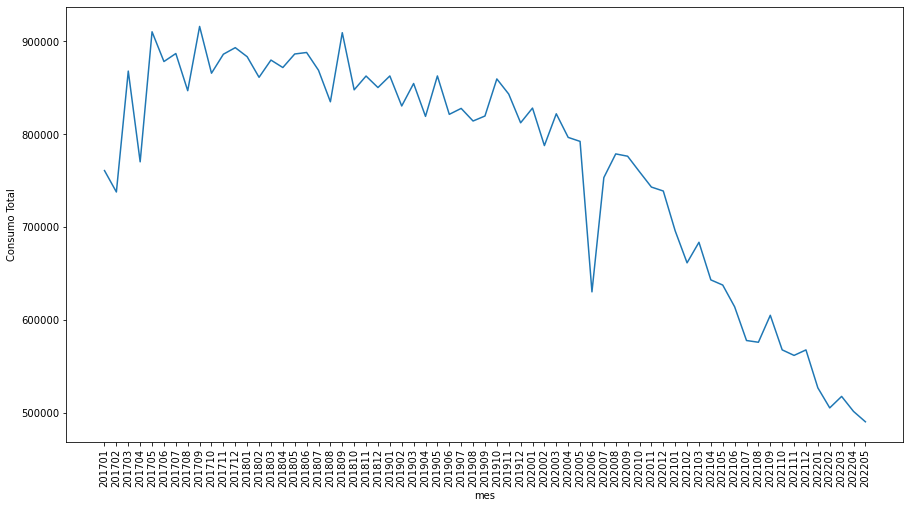

In [17]:
plot_target_behavior(df,'consumoacumuladodomes')

## Teste de estacionaridade

In [18]:
adf_test(df['consumoacumuladodomes'])

Resultado do Teste Dickey-Fuller:
Teste                      1.414744
Valor p                    0.997180
# de lags                  3.000000
# de observações          61.000000
Valores Críticos (1%)     -3.542413
Valores Críticos (5%)     -2.910236
Valores Críticos (10%)    -2.592745
dtype: float64


## Média Móvel

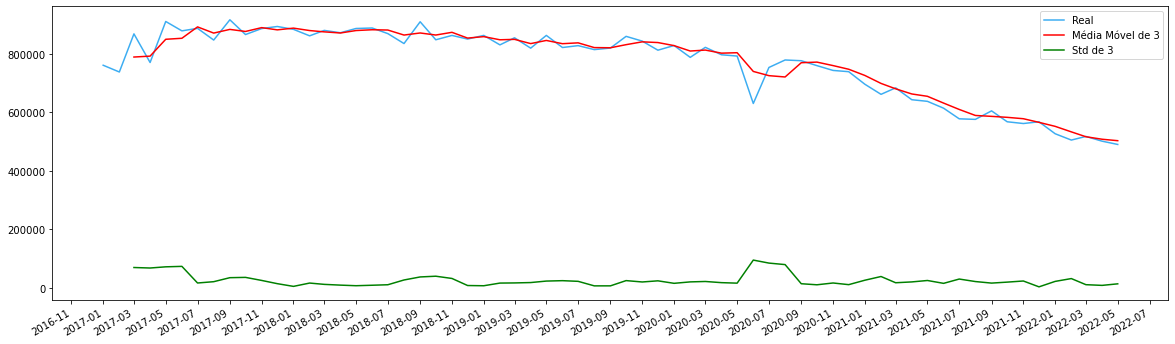

In [19]:
plot_moving_average(df,'consumoacumuladodomes', 3)

## Decomposição da série

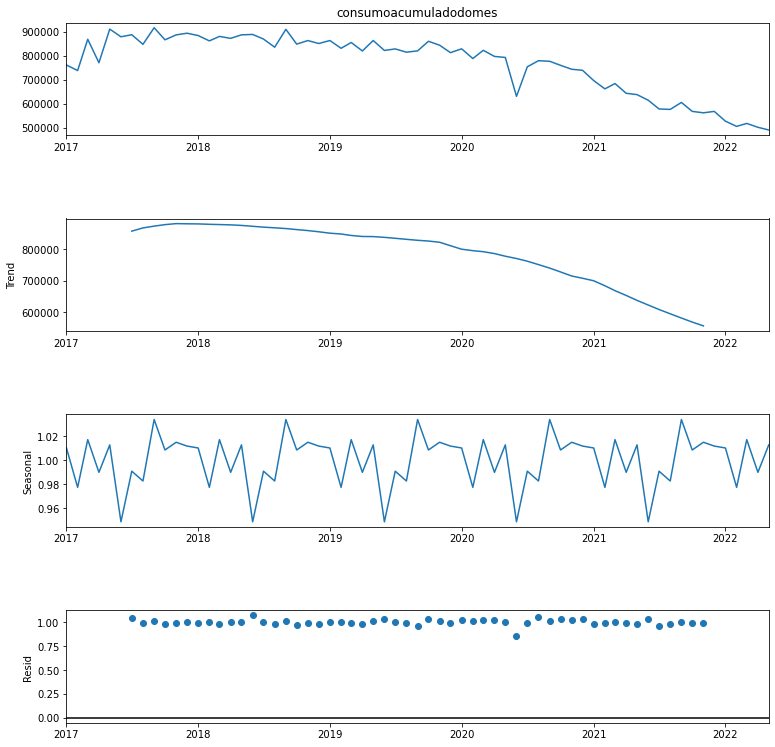

In [22]:
decompose_data = serie_decompose(df,'consumoacumuladodomes')

### Sazonalidade da série

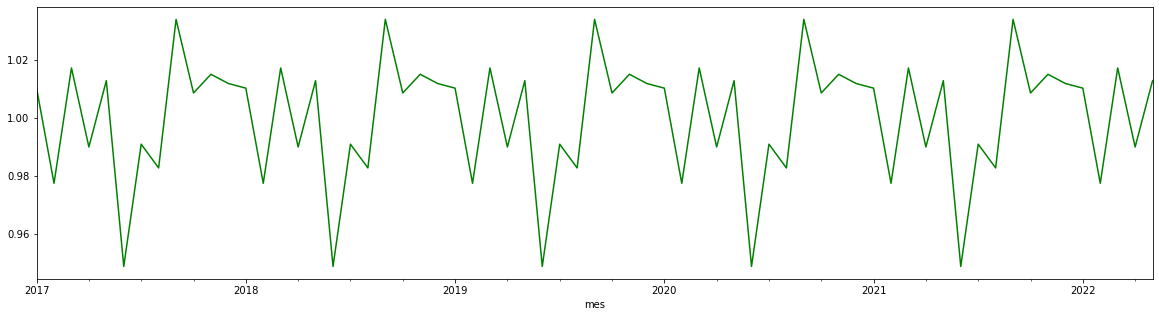

In [23]:
seasonality = plot_seasonality(decompose_data)

In [24]:
seasonality

mes
2017-01-01    1.010267
2017-02-01    0.977510
2017-03-01    1.017226
2017-04-01    0.990012
2017-05-01    1.012851
                ...   
2022-01-01    1.010267
2022-02-01    0.977510
2022-03-01    1.017226
2022-04-01    0.990012
2022-05-01    1.012851
Name: seasonal, Length: 65, dtype: float64

## Gráfico de diferenciações, autocorrelações e autocorrelações parciais

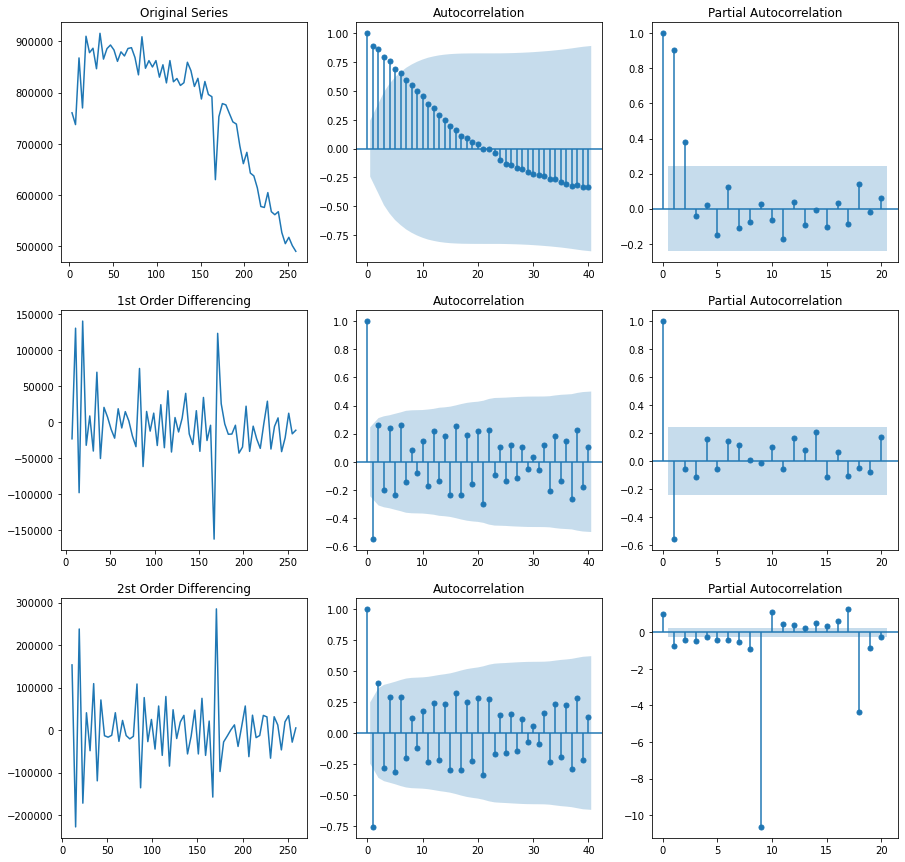

In [126]:
plot_diff_acp_pacf(df, 'consumoacumuladodomes')

## Diferenciação de primeira ordem e teste de estacionariedade na série diferenciada

Resultado do Teste Dickey-Fuller:
Teste                    -5.812392e+00
Valor p                   4.370690e-07
# de lags                 2.000000e+00
# de observações          6.100000e+01
Valores Críticos (1%)    -3.542413e+00
Valores Críticos (5%)    -2.910236e+00
Valores Críticos (10%)   -2.592745e+00
dtype: float64
None


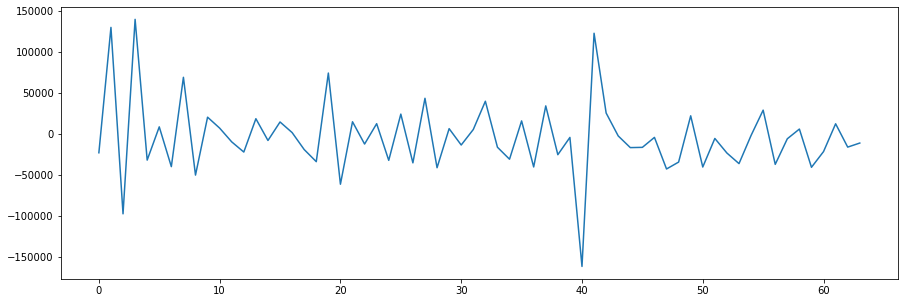

In [25]:
df_diff = serie_differentiation(df,'consumoacumuladodomes')

In [26]:
df_diff

array([ -23076.55,  130274.1 ,  -97773.26,  140116.56,  -32048.  ,
          8616.1 ,  -40038.  ,   69229.5 ,  -50396.9 ,   20467.1 ,
          7073.7 ,   -9765.6 ,  -22195.2 ,   18581.  ,   -8040.3 ,
         14588.3 ,    1615.4 ,  -19143.8 ,  -33962.4 ,   74441.6 ,
        -61552.4 ,   14851.7 ,  -12406.9 ,   12497.6 ,  -32351.8 ,
         24213.64,  -35418.33,   43563.82,  -41383.1 ,    6408.19,
        -13579.37,    5372.49,   39949.02,  -16301.97,  -30966.12,
         15896.22,  -40432.21,   34255.52,  -25434.99,   -4302.49,
       -162131.37,  123116.57,   25535.03,   -2498.16,  -16763.94,
        -16455.78,   -4266.35,  -42905.06,  -34471.28,   22133.92,
        -40520.83,   -5560.24,  -23413.58,  -36346.36,   -1870.09,
         29057.4 ,  -37259.44,   -5968.7 ,    5914.98,  -40854.12,
        -21610.43,   12367.71,  -16156.4 ,  -11184.2 ])

## Autocorreação por número de meses

In [27]:
autocorrelation_lag(df, 'consumoacumuladodomes')

Um mês:  0.9285518970767378
Três meses:  0.9103165701834612
Seis meses:  0.8976239604934657
Nove meses:  0.8420321104684085
Doze meses:  0.8188330526298606


## Divisão em treino e teste

In [37]:
date_split = dt.datetime(2022, 1, 1)
date_end = dt.datetime(2022, 12, 1)

#xtrain, xtest, interval_start, interval_end, dataset = train_test_split_data(df, 'consumoacumuladodomes', '2022-06-01', 7, 'M', date_split, date_end, True)
xtrain, xtest, interval_start, interval_end, dataset = train_test_split_data(df, 'consumoacumuladodomes', '2022-06-01', 7, 'M', date_split, date_end, False)

Train interval:  2017-01-01  até  2021-12-01
Test interval:  2022-01-01  até  2022-12-01
Test interval:  60  até  71


## Execução do auto arima

In [40]:
stepwise_model = automatic_arima(xtrain, start_p=1, start_q=1,max_p=6, max_q=6, m=12, start_P=0, seasonal=True, d=1, D=1, trace=True, n_jobs = 1)

 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1164.658, Time=0.01 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=1163.122, Time=0.03 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=1157.995, Time=0.08 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=1160.742, Time=0.04 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=inf, Time=0.19 sec
 ARIMA(0,1,0)(1,1,2)[12]             : AIC=1159.229, Time=0.27 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=1158.416, Time=0.06 sec
 ARIMA(0,1,0)(2,1,1)[12]             : AIC=inf, Time=0.42 sec
 ARIMA(0,1,0)(2,1,2)[12]             : AIC=inf, Time=0.37 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=1169.885, Time=0.01 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1162.984, Time=0.05 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=1160.680, Time=0.10 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=1165.079, Time=0.04 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=inf, Time=0.31 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=inf, Time=0.44 sec
 ARIMA(0,1,1)(2,1,0)

## Predição e validação do modelo

In [56]:
xtest['pred'] = stepwise_model.predict(n_periods=12)

In [53]:
y_true = xtest[~xtest['consumoacumuladodomes'].isna()]['consumoacumuladodomes'].values
y_pred = future_forecast.iloc[0:5, :].values

validation_metrics(y_true, y_pred)

MAPE: 6.42, RMSE: 32660.85, MAE: 32279.24


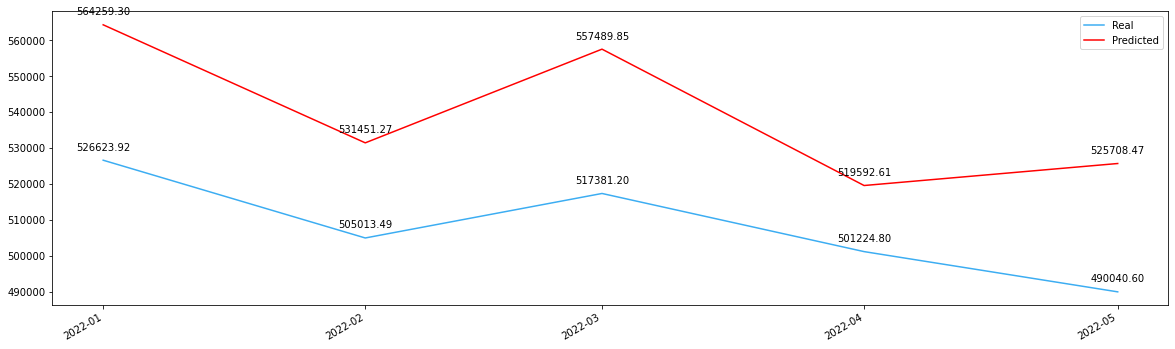

In [76]:
plot_predict_x_real(xtest, 'consumoacumuladodomes', 'pred')

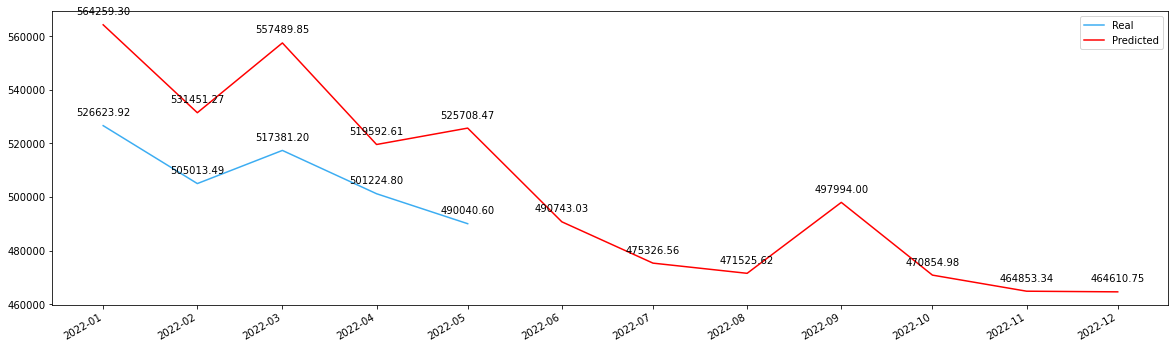

In [77]:
plot_year_behavior(xtest, 'consumoacumuladodomes', 'pred')

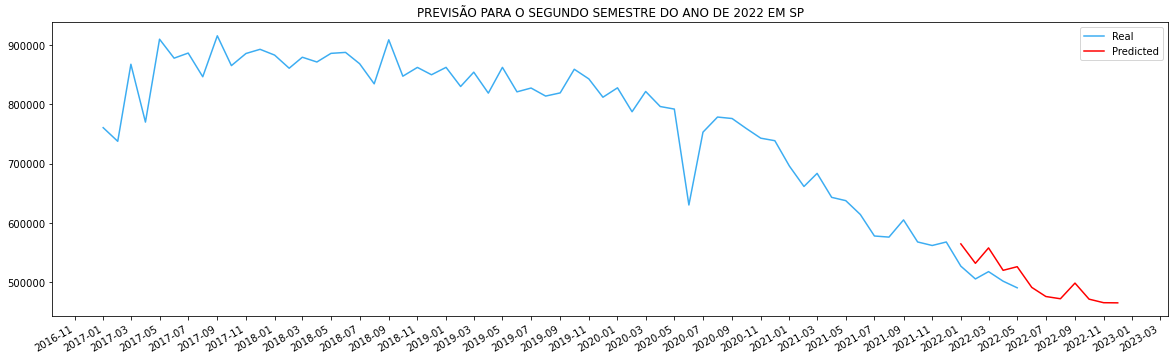

In [78]:
plot_serie_behavior(df, xtest, interval_start, 'consumoacumuladodomes', 'pred', "PREVISÃO PARA O SEGUNDO SEMESTRE DO ANO DE 2022 EM SP")

## Execução do Sarimax

In [100]:
sarimax, df_test = sarimax_algorithm(xtrain, xtest, 'consumoacumuladodomes', interval_start, interval_end, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12), normalization= True)

## Predição e validação do modelo

In [101]:
df_test

,consumoacumuladodomes,pred
mes,,
2022-01-01,526623.92,540845.514236
2022-02-01,505013.49,506439.088105
2022-03-01,517381.20,533908.903645
2022-04-01,501224.80,498573.500686
2022-05-01,490040.60,501735.494143
2022-06-01,NaN,437104.485052
2022-07-01,NaN,452804.666634
2022-08-01,NaN,455765.939246
2022-09-01,NaN,475669.180390


In [103]:
y_true = df_test[~df_test['consumoacumuladodomes'].isna()]['consumoacumuladodomes'].values
y_pred = df_test[~df_test['consumoacumuladodomes'].isna()]['pred'].values

validation_metrics(y_true, y_pred)

MAPE: 1.82, RMSE: 11146.76, MAE: 9304.22


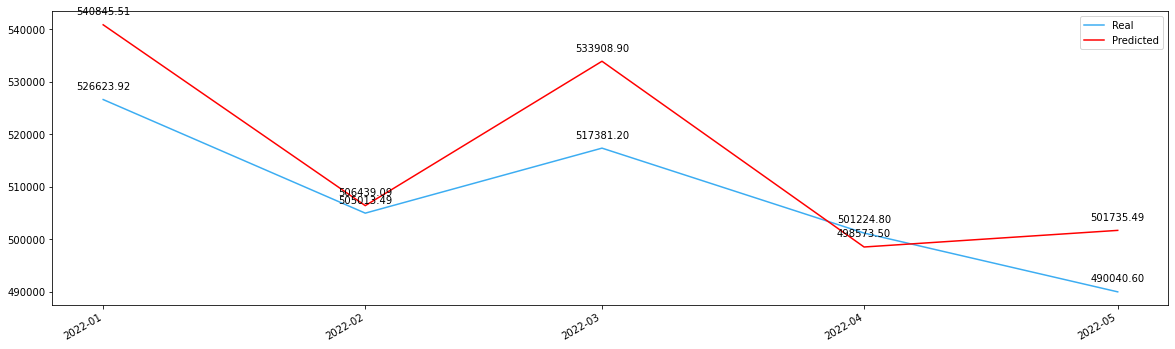

In [105]:
plot_predict_x_real(df_test, 'consumoacumuladodomes', 'pred')

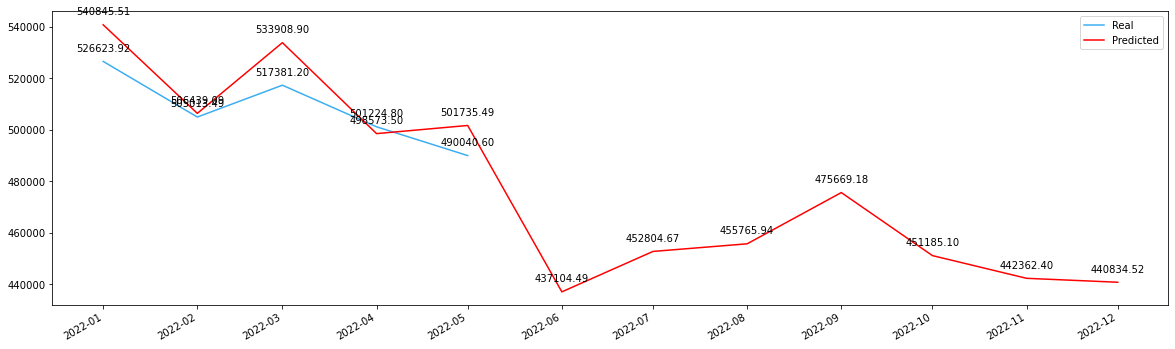

In [106]:
plot_year_behavior(df_test, 'consumoacumuladodomes', 'pred')

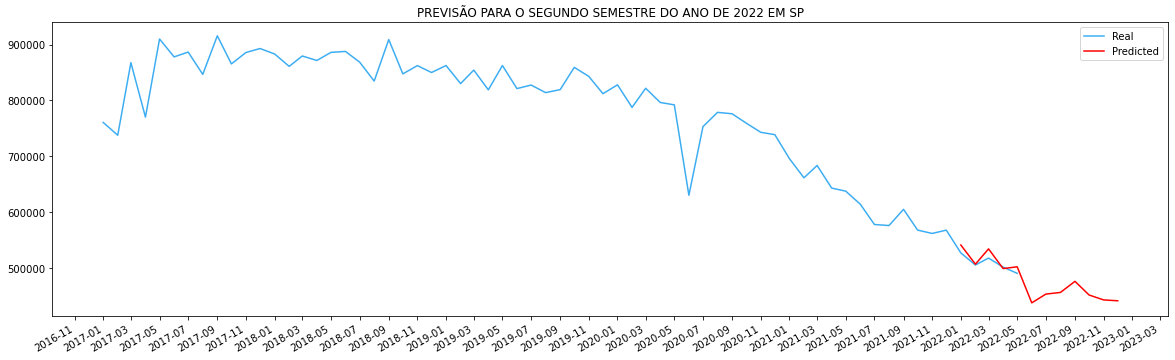

In [102]:
plot_serie_behavior(df, df_test, interval_start, 'consumoacumuladodomes', 'pred', "PREVISÃO PARA O SEGUNDO SEMESTRE DO ANO DE 2022 EM SP")

In [104]:
y_pred - y_true

array([14221.59423594,  1425.59810539, 16527.70364543, -2651.29931362,
       11694.89414272])